# Формулировка задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

# Подготовка данных

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from scipy import stats as st

## Загружаем данные

In [2]:
try:
    df_contract= pd.read_csv('C:\\Users\\user\\Yandex\\Final_project\\datasets\\contract.csv')
    df_personal= pd.read_csv('C:\\Users\\user\\Yandex\\Final_project\\datasets\\personal.csv')
    df_internet= pd.read_csv('C:\\Users\\user\\Yandex\\Final_project\\datasets\\internet.csv')
    df_phone= pd.read_csv('C:\\Users\\user\\Yandex\\Final_project\\datasets\\phone.csv')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Договоры

In [3]:
df_contract.head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5


In [4]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
len(df_contract['customerID'].unique())

7043

### Персональные данные клиента

In [6]:
df_personal.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


In [7]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
len(df_personal['customerID'].unique())

7043

### Интернет-услуги

In [9]:
df_internet.head(2)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


In [10]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
len(df_internet['customerID'].unique())

5517

### Телефония

In [12]:
df_phone.head(2)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No


In [13]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
len(df_phone['customerID'].unique())

6361

### Вывод

1. Во всех датасетах customerID содержит уникальный код клиента. Дубликатов внутри каждого датасета по этому полю нет.  Можем сцепить таблицу в одну по customerID.
2. В таблицах есть колонки, которые содержат значения yes/no , можем перевести их в бинарный вид(значения 1 и 0).
3. BeginDate надо перевести в формат даты.
4. EndDate будет нашим target. Если даты нет, то клиент действующий.
5. Вместо BeginDate и EndDate можем оставить колонку с информацией о том, сколько уже дней клиент с нами сотрудничает. Если EndDate отсутствует, то присвоим ему значение с датой актуальности датасета (1 февраля 2020)
6. TotalCharges имеет тип object, хотя должен быть числовой. Надо найти нечисловые значения и разобраться с чем это может быть связано.
7. Больше всего строк в датасетах df_contract и df_personal. Это говорит о том, что есть клиенты, которые пользуются только одним продуктом (телефония или интернет).

## Предобработка данных

### Объединение датафреймов

In [15]:
df = df_contract.merge(df_personal, on = 'customerID')
df = df.merge(df_internet, on = 'customerID',how='left')
df = df.merge(df_phone, on = 'customerID',how='left')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


### Работа с пропусками

Во всех колонках кроме MultipleLines заполним пропуски значением 'No'. В MultipleLines значение 'No' означает, что клиент пользуется телефоном, но не использует доп услугу многоканальной линии. Поэтому в MultipleLines заменим пропуски на 'No phone' 

In [17]:
df.MultipleLines.fillna('No phone', inplace = True)
df.fillna('No',inplace = True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
MultipleLines       7043 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


Посмотрим как выглядят записи, из-за которых TotalCharges имеет тип object

In [19]:
df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No phone
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No phone


In [20]:
df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()].BeginDate.unique()

array(['2020-02-01'], dtype=object)

TotalCharges имеет пустые записи для договоров , которые открыты 2020-02-01 (дата актуальности выборки). Это только что заключенные договоры и для целй нашей задачи они не информативны. Удалим их.

In [21]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace = True)

### Добавление столбца ContractClosed

Посмотрим какие уникальные значения принимают колонки.

In [22]:
for col in df:
    print(col, df[col].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
BeginDate ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-

Добавим столбец ContractClosed, в нем будет содержаться информация закрыт контракт или нет. 

In [23]:
df['ContractClosed'] = (df['EndDate'] != 'No')*1

### Добавление столбца ContractTerm

Добавим столбец ContractTerm , в котором будет считаться длина конракта. Для этого сначала 

In [24]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

In [25]:
df['EndDate'] = pd.to_datetime(
    df['EndDate'], format='%Y-%m-%dT')
df['BeginDate'] = pd.to_datetime(
    df['BeginDate'], format='%Y-%m-%dT')
df['ContractTerm_day'] = (df['EndDate'] - df['BeginDate'])/np.timedelta64(1, 'D')
df['ContractTerm_month'] = (df['EndDate'] - df['BeginDate'])/np.timedelta64(1, 'M')
df['ContractTerm_day'] = df['ContractTerm_day'].astype(int)
df['ContractTerm_month'] = df['ContractTerm_month'].astype(int)

# Исследование данных

Посмотрим пропорцию открытых и закрытых договоров

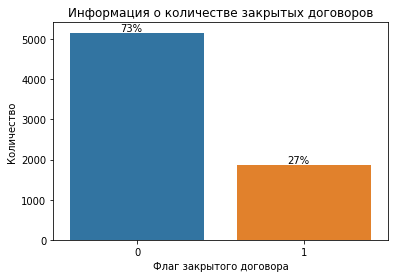

In [26]:
ax = sns.countplot(x='ContractClosed', data=df)
plt.title('Информация о количестве закрытых договоров')
plt.xlabel('Флаг закрытого договора')
plt.ylabel('Количество')

for p in ax.patches:
        ax.annotate('{:.0f}%'.format(p.get_height()/df['ContractClosed'].count()*100), (p.get_x()+0.3, p.get_height()+50))

Закрытые договоры занимают 27% датасета. Посмотрим различаются ли наборы данных по закрытым и открытым договорам в разрезе остальных признаков.

In [27]:
# создадим функцию для построения графиков в разрезе закрытых и открытых договоров
def FacetGrid_df (data, column):
    g = sns.FacetGrid(data, col = 'ContractClosed')
    g.map(sns.countplot, column, order = data[column].unique(), palette = 'Set1')    

## Анализ персональных данных

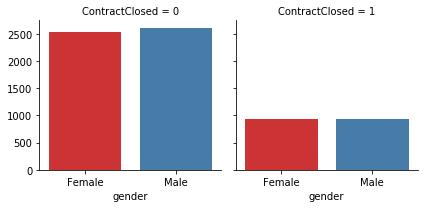

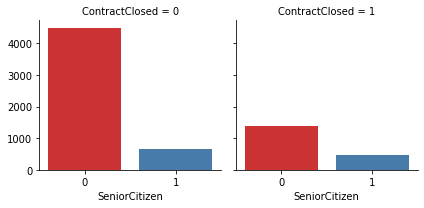

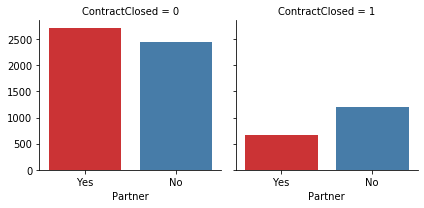

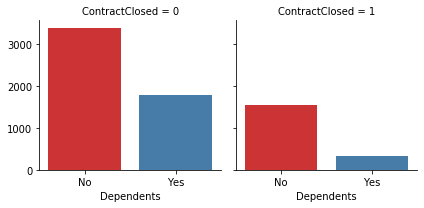

In [28]:
for col in df_personal:
    if col != 'customerID':
        FacetGrid_df(df, col) 

В действующих договорах доля пенсионеров значительно ниже, чем в закрытых. Договоры закрывают чаще те, кто не находится в браке. В остальном рисунок клиента в двух наборах сопоставим.

## Анализ интернет-услуг

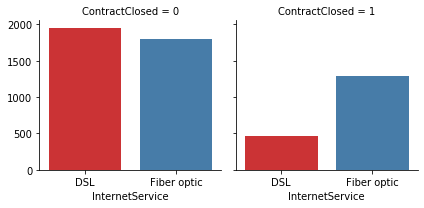

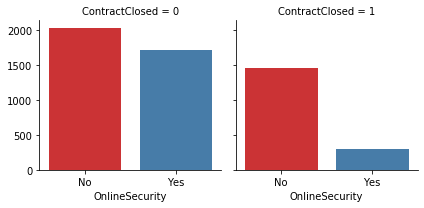

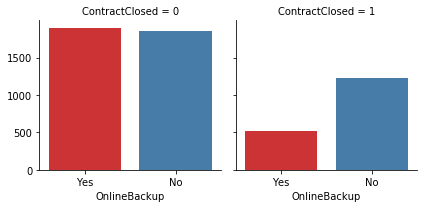

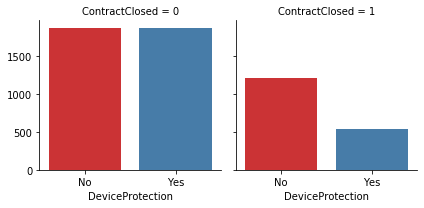

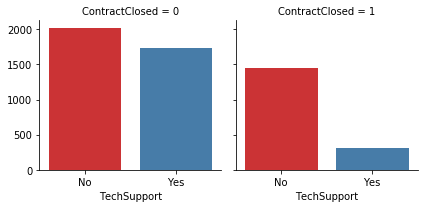

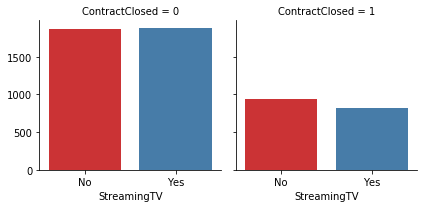

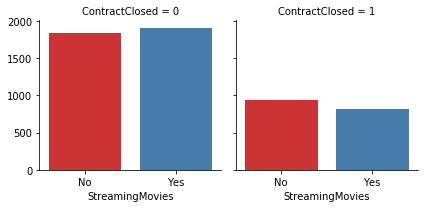

In [29]:
for col in df_internet:
    if col != 'customerID':
        FacetGrid_df(df[df['InternetService'] != 'No'],col) 

1. В закрытых договорах преобладает Fiber Optic. Это можем быть связано с низким качеством услуги или ее завышенной стоимости. С другой стороны перекос может быть связан с тем , что клиенты с DSL не уходят, потому что у них пока нет технической возможности для альтернативных вариантов.
2. Клиенты , у которых есть доп сервисы (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport) значительно реже расторгают договоры. Подключение доп услуг говорит о лояльности клиента к компании.

## Анализ телефонии

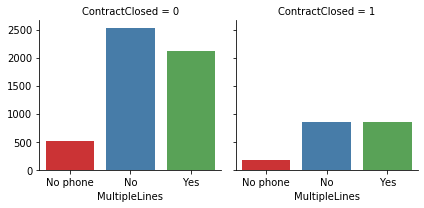

In [30]:
FacetGrid_df(df,'MultipleLines') 

В закрытых договорах доля клиентов с подключенным MultipleLines больше. 

## Анализ договоров

In [31]:
set = ['Type','PaperlessBilling']

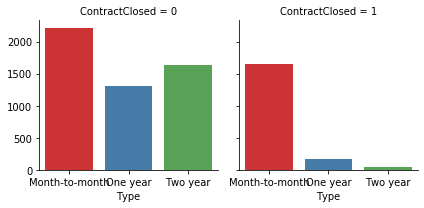

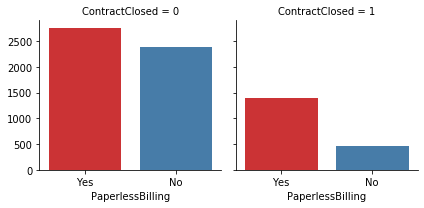

In [32]:
for col in set:
    FacetGrid_df(df,col) 

1. Контракты с ежегодной оплатой значительно реже расторгают договоры.
2. Чаще расторгают контракты те, у кого подключена услуга PaperlessBilling

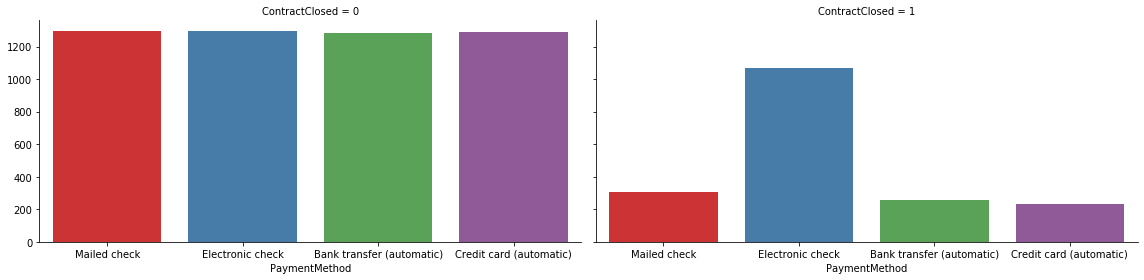

In [33]:
g = sns.FacetGrid(df, col = 'ContractClosed',height=4, aspect = 2)
g.map(sns.countplot, 'PaymentMethod', palette = 'Set1'); 

Больше всего расторгают контракты те, кто использует метод оплаты Electronic check.

## Анализ ежемесячных платежей

Посмотрим как выглядит ситуация по показателю месячного платежа.

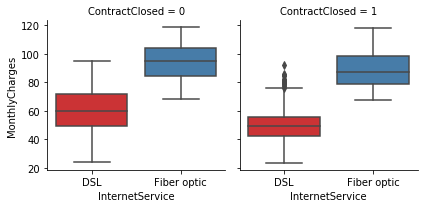

In [34]:
g = sns.FacetGrid(df[df['InternetService'] != 'No'], col = 'ContractClosed')
g.map(sns.boxplot, 'InternetService', 'MonthlyCharges',palette = 'Set1');

У закрытых договоров медианная стоимость месячного платежа ниже, чем у активных. Скорее всего это связано с тем, что чаще уходят клиенты, которые не пользуются доп услугами (было выявлено ранее)

## Анализ срока жизни контракта

Посмотрим распределение по сроку жизни контракта.

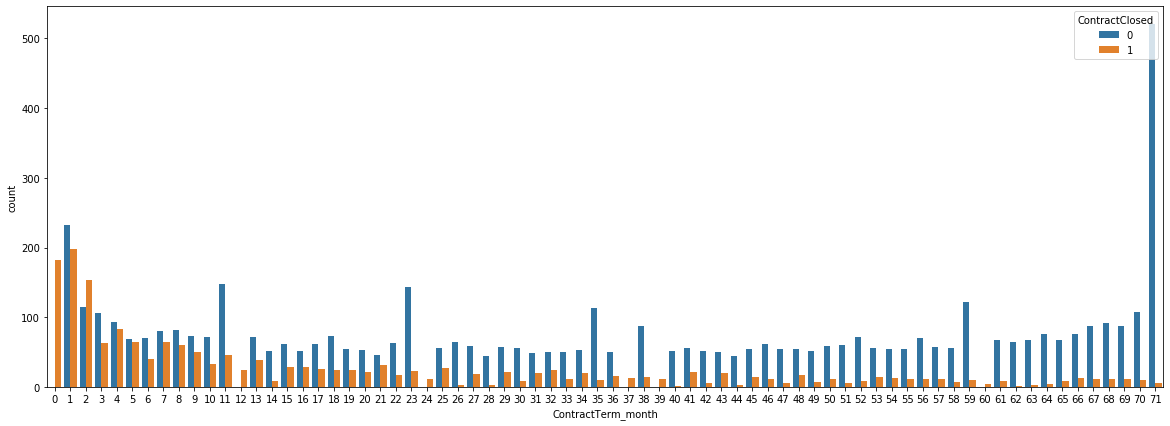

In [35]:
plt.figure(figsize = (20, 7))
sns.countplot(x = df['ContractTerm_month'], hue = df['ContractClosed']);

В первые месяцы происходит наибольший отток клиентов. После первого года количество уходящих клиентов ощутимо снижается.

## Вывод по исследованию данных

1. В рамках интернет услуг подключение доп сервисов (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport) увеличивают лояльность клиента к компании.
2. Чаще уходят клиенты у которых:
 - ежемесячная оплата 
 - используют для оплаты electronic check
 - используют Fiber Optic
3. Основной пул клиентов уходит в течение первого года.

Проверим гипотезы из п.1. вывода

## Проверка гипотез

In [36]:
#критический уровень статистической значимости
alpha = 0.01

col_names = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

for col in col_names: 
    ttest_res = st.ttest_ind(df[df[col] == 'Yes']['ContractClosed'], df[df[col] != 'Yes']['ContractClosed'])
    print('Признак ', col)
    print('p-значение:', ttest_res.pvalue) 

    if ttest_res.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    print()

Признак  OnlineSecurity
p-значение: 1.9684264282341907e-47
Отвергаем нулевую гипотезу

Признак  OnlineBackup
p-значение: 4.761165243685329e-12
Отвергаем нулевую гипотезу

Признак  DeviceProtection
p-значение: 2.7632096948355908e-08
Отвергаем нулевую гипотезу

Признак  TechSupport
p-значение: 5.889778010672642e-44
Отвергаем нулевую гипотезу



Нулевые гипотезы отвергнуты, значит интернет доп услуги значимы для ContractClosed.

# План по дальнейшему решению задачи

1. Подготовить датасет к обучению:
    - убрать лишние колонки (даты начала и конца)
    - кодировать категориальные переменные
    - выделить feature и target
    - разделить датасет на train и test
2. Попробовать различные модели для решения задачи классификации. Проверить результат на метриках AUC-ROC и accuracy
3. Сравнить результат моделей с DummyClassifier
4. Сделать выводы по выбору лучшей модели и работы в целом. 

# Подготовка датасетов

## Уберем лишние колонки

In [37]:
df = df.drop(columns=['BeginDate', 'EndDate','customerID','ContractTerm_month'])

## Проверим на мультиколлинеарность количественные признаки

In [38]:
numeric = ['MonthlyCharges', 'TotalCharges', 'ContractTerm_day']
df[numeric].corr()

,MonthlyCharges,TotalCharges,ContractTerm_day
MonthlyCharges,1.000000,0.651065,0.246715
TotalCharges,0.651065,1.000000,0.825811
ContractTerm_day,0.246715,0.825811,1.000000


Сила корреляции TotalCharges и ContractTerm_day больше 0,8. Удалим TotalCharges из датасета, т.к. у него также достаточно сильная корреляция с MonthlyCharges.

In [39]:
df = df.drop(columns=['TotalCharges'])

## Преобразуем категориальные признаки в численные 

In [40]:
# сохраним список категориальных признков
cat_features = [ 'Type', 'PaperlessBilling', 'PaymentMethod',
       'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines']

In [41]:
for i in cat_features:
    df[i] = LabelEncoder().fit_transform(df[i])

In [42]:
df_ohe = pd.get_dummies(df, columns = cat_features, drop_first = True)

In [43]:
df_ohe.head()

,MonthlyCharges,ContractClosed,ContractTerm_day,Type_1,Type_2,PaperlessBilling_1,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,gender_1,...,InternetService_1,InternetService_2,OnlineSecurity_1,OnlineBackup_1,DeviceProtection_1,TechSupport_1,StreamingTV_1,StreamingMovies_1,MultipleLines_1,MultipleLines_2
0,29.85,0,31,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,56.95,0,1036,1,0,0,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
2,53.85,1,61,0,0,1,0,0,1,1,...,0,0,1,1,0,0,0,0,0,0
3,42.30,0,1371,1,0,0,0,0,0,1,...,0,0,1,0,1,1,0,0,1,0
4,70.70,1,61,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [44]:
target = df_ohe['ContractClosed']
features = df_ohe.drop('ContractClosed', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

## Масштабируем признаки

In [45]:
numeric = ['MonthlyCharges', 'ContractTerm_day']

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]) 

# Обучаем модели

In [281]:
#результирующая таблица
results = pd.DataFrame(columns = ['roc_auc_score','accuracy_score'])

## Логичтическая регрессия

In [282]:
model_lr = LogisticRegression( random_state=12345)
model_lr.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [283]:
probabilities_test = model_lr.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_test)

In [284]:
acc = accuracy_score(target_test, model_lr.predict(features_test))

In [285]:
results.loc['lr'] = [roc_auc,acc]

## LGBM

In [286]:
lgbm = LGBMClassifier (max_depth = 5, n_estimators = 500)

In [287]:
lgbm.fit(features_train, target_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [288]:
probabilities_test = lgbm.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_test)

acc = accuracy_score(target_test, lgbm.predict(features_test))

In [289]:
results.loc['lgbm'] = [roc_auc,acc]

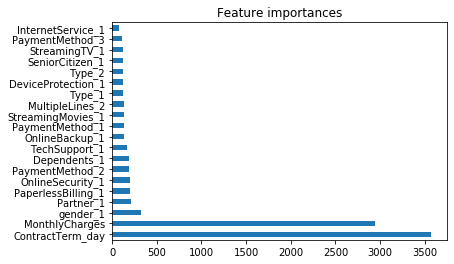

In [290]:
plt.title("Feature importances")
feat_importances = pd.Series(lgbm.feature_importances_, index=features_train.columns)
feat_importances.nlargest(20).plot(kind='barh');

## RandomForestClassifier

In [291]:
forest = RandomForestClassifier(random_state = 12345)
params = {
    'max_depth' : range(9,15,2),
    'n_estimators' : range (10,51,10)
}
forest_model = RandomizedSearchCV (forest,params, cv=2, random_state = 12345)

In [292]:
forest_model.fit(features_train, target_train)

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [293]:
best_forest_model = forest_model.best_estimator_
probabilities_test = best_forest_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_test)

acc = accuracy_score(target_test, best_forest_model.predict(features_test))

In [294]:
results.loc['forest'] = [roc_auc,acc]

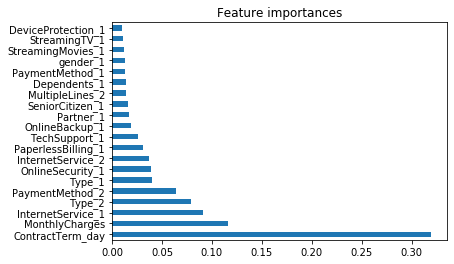

In [295]:
plt.title("Feature importances")
feat_importances = pd.Series(best_forest_model.feature_importances_, index=features_train.columns)
feat_importances.nlargest(20).plot(kind='barh');

## DummyClassifier

In [296]:
model_dummy_clf = DummyClassifier(strategy="most_frequent")
model_dummy_clf.fit(features_test, target_test)

probabilities_test = model_dummy_clf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_test)

acc = accuracy_score(target_test, model_dummy_clf.predict(features_test))

In [297]:
results.loc['dummy_clf'] = [roc_auc,acc]

# Вывод

In [298]:
results

,roc_auc_score,accuracy_score
lr,0.849305,0.805970
lgbm,0.911619,0.867093
forest,0.860021,0.814499
dummy_clf,0.500000,0.727790


По итогам обучения разных моделей лучший roc_auc показала модель LGBMClassifier (0,91). При подготовке датасета были убраны лишние столбцы ( столбцы с датами, id, TotalCharges). Создан столбец с продолжительностью контратка в днях. Категориальные признаки были переведены в численные. Произведена стандартизация численных значений. Опробованы модели LogisticRegression, LGBMClassifier, RandomForestClassifier, DummyClassifier. Самыми важными признаками для моделей были столбцы ContractTerm_day и MonthlyCharges

# Финальный отчет

Все пункты из плана по решению задачи выполнены:

1. Датасет подготовлен к обучению
    - убраны лишние колонки ('BeginDate', 'EndDate', 'customerID', 'ContractTerm_month', 'TotalCharges')
    - закодированы категориальные переменные (сначала применен LabelEncoder, затем pd.get_dummies) 
    - числовые признаки отмасштабированы
    - выделены feature и target (target - колонка ContractClosed)
    - датасет разделен на train и test (размер тестовой выборки - 20%)
2. Попробованы модели LogisticRegression, LGBMClassifier, RandomForestClassifier для решения задачи классификации. Результаты проверены на метриках AUC-ROC и accuracy
3. Результаты всех моделей оказались лучше, чем у DummyClassifier
4. Лучшие показатели оказались у модели LGBMClassifier: roc_auc = 0,91 ,  accuracy = 0,86